In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
logs_df = pd.read_csv('training_logs.txt', sep='\t')
logs_df.head()

,epoch,seed,train,shuffle,accuracy,loss
0,1,10,True,False,30.204,0.029692
1,1,10,False,False,42.210,0.024462
2,2,10,True,False,47.410,0.022343
3,2,10,False,False,54.880,0.020095
4,3,10,True,False,61.142,0.017035


In [3]:
colors = {
    'train': '#E67E22', # orange
    'test': '#148F77' #green
}
lines = {
    'shuffle': '-',
    'noshuffle': '--'
}

---

In [4]:
accuracies = {}
losses = {}
train_shuffle_df = logs_df[['epoch', 'accuracy', 'loss']].loc[(logs_df['train']) & (logs_df['shuffle'])]
accuracies['train_shuffle'], losses['train_shuffle'] = train_shuffle_df.groupby('epoch').mean().values.T

test_shuffle_df = logs_df[['epoch', 'accuracy', 'loss']].loc[~(logs_df['train']) & (logs_df['shuffle'])]
accuracies['test_shuffle'], losses['test_shuffle'] = test_shuffle_df.groupby('epoch').mean().values.T

train_noshuffle_df = logs_df[['epoch', 'accuracy', 'loss']].loc[(logs_df['train']) & ~(logs_df['shuffle'])]
accuracies['train_noshuffle'], losses['train_noshuffle'] = train_noshuffle_df.groupby('epoch').mean().values.T

test_noshuffle_df = logs_df[['epoch', 'accuracy', 'loss']].loc[~(logs_df['train']) & ~(logs_df['shuffle'])]
accuracies['test_noshuffle'], losses['test_noshuffle'] = test_noshuffle_df.groupby('epoch').mean().values.T

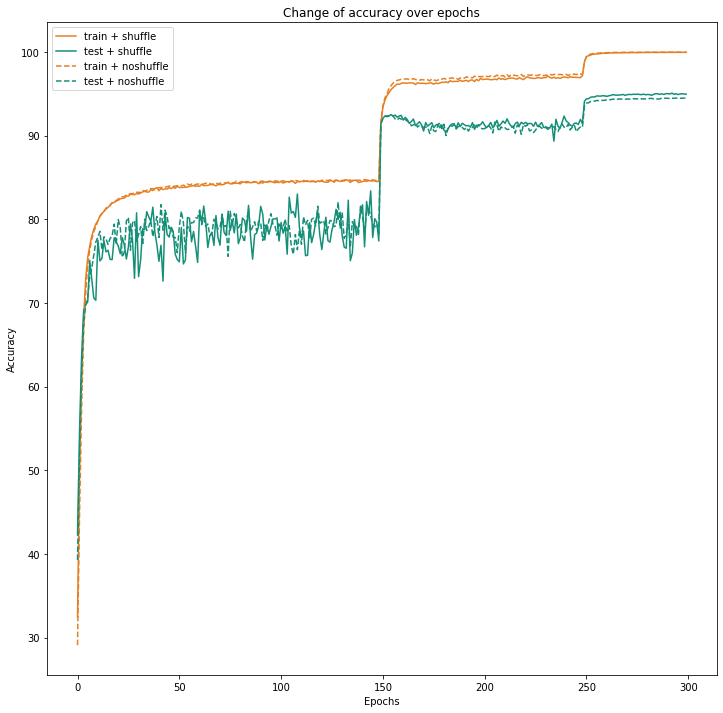

In [9]:
plt.figure(figsize=(12,12))
for category, values in accuracies.items():
    train, shuffle = category.split('_')
    plt.plot(range(len(values)), values, label=' + '.join([train, shuffle]), color=colors[train], linestyle=lines[shuffle])
plt.title('Change of accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.savefig('accuracy.jpg', format='jpg')

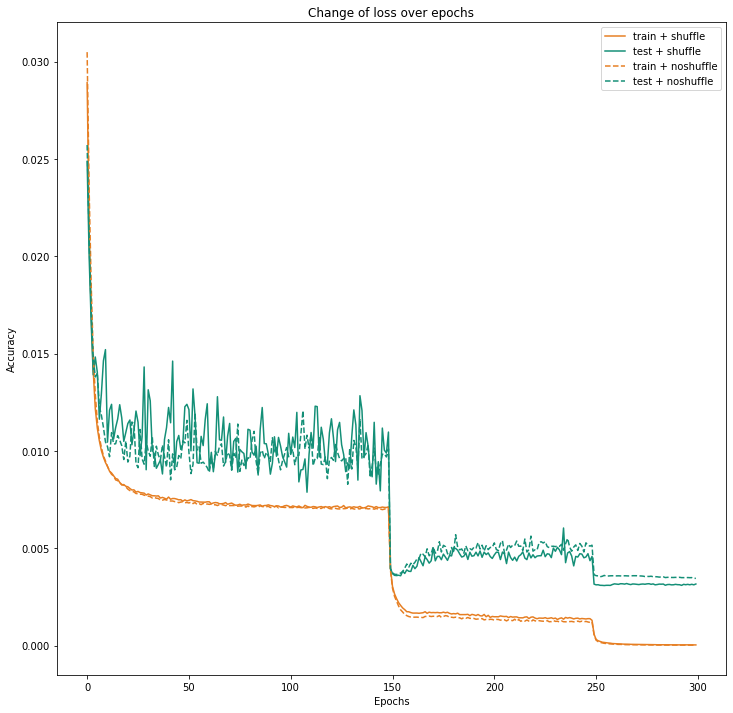

In [10]:
plt.figure(figsize=(12,12))
for category, values in losses.items():
    train, shuffle = category.split('_')
    plt.plot(range(len(values)), values, label=' + '.join([train, shuffle]), color=colors[train], linestyle=lines[shuffle])
plt.title('Change of loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.savefig('loss.jpg', format='jpg')